### <font color='#FF93D5'> [0] <u>Initialization</u> </font>

In [124]:
# remove residues from notebook
!rm -rf sample_data

# get the zip containing the cat images
!wget https://github.com/Crash285github/nyaural_catwork/raw/main/data/cats.zip -P data/

# extract the cats into data/
from zipfile import ZipFile
with ZipFile('data/cats.zip', 'r') as cats:
  cats.extractall('data')

# remove the downloaded zip
!rm data/cats.zip

--2024-01-05 16:10:40--  https://github.com/Crash285github/nyaural_catwork/raw/main/data/cats.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Crash285github/nyaural_catwork/main/data/cats.zip [following]
--2024-01-05 16:10:40--  https://raw.githubusercontent.com/Crash285github/nyaural_catwork/main/data/cats.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49466575 (47M) [application/zip]
Saving to: ‘data/cats.zip’

cats.zip            100%[===================>]  47.17M   173MB/s    in 0.3s    

2024-01-05 16:10:41 (173 MB/s) - ‘data/cats.zip’ saved [49466575/49466575]



### <font color='#FF7580'>[1] <u>Data manipulation</u> </font>

#### <font color='#777'> [1.0] Imports, parameters</font>

In [125]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as tforms
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# how to divide the dataset later on
train_frac, val_frac, test_frac = 7, 2, 1

# show dataset images on [1.3.1]
visualize_datasets = True
# how many images to show
number_of_samples = 5

#### <font color='#C45A63'> [1.1] Dataset class</font>

In [126]:
class CatDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = []

        for img in os.listdir(main_dir):
            if img.endswith(".zip"):
                continue
            img_loc = os.path.join(self.main_dir, img)
            image = Image.open(img_loc).convert('RGB')
            tensor_image = self.transform(image)
            self.total_imgs.append(tensor_image)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        return self.total_imgs[idx]

#### <font color='#C45A63'>[1.2] Dataset details</font>

In [127]:
# image transformations
transforms = tforms.Compose([
  tforms.ToTensor(),
  tforms.Grayscale()
])

# normalize divisions
n_train_frac = train_frac / (train_frac + val_frac + test_frac)
n_val_frac = val_frac / (train_frac + val_frac + test_frac)
n_test_frac = test_frac / (train_frac + val_frac + test_frac)

print(f'{(n_train_frac*100):.1f} % Training data')
print(f'{(n_val_frac*100):.1f} % Validation data')
print(f'{(n_test_frac*100):.1f} % Testing data')

70.0 % Training data
20.0 % Validation data
10.0 % Testing data


#### <font color='#C45A63'>[1.3] Create Datasets</font>

In [128]:
# create the dataset
dataset = CatDataset('data', transforms)

# split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train_frac, n_val_frac, n_test_frac])

print(f'{len(train_dataset)}\ttraining images')
print(f'{len(val_dataset)}\tvalidating images')
print(f'{len(test_dataset)}\ttesting images')

11023	training images
3150	validating images
1574	testing images


##### <font color='#777'>[1.3.1] Visualize Datasets </font>

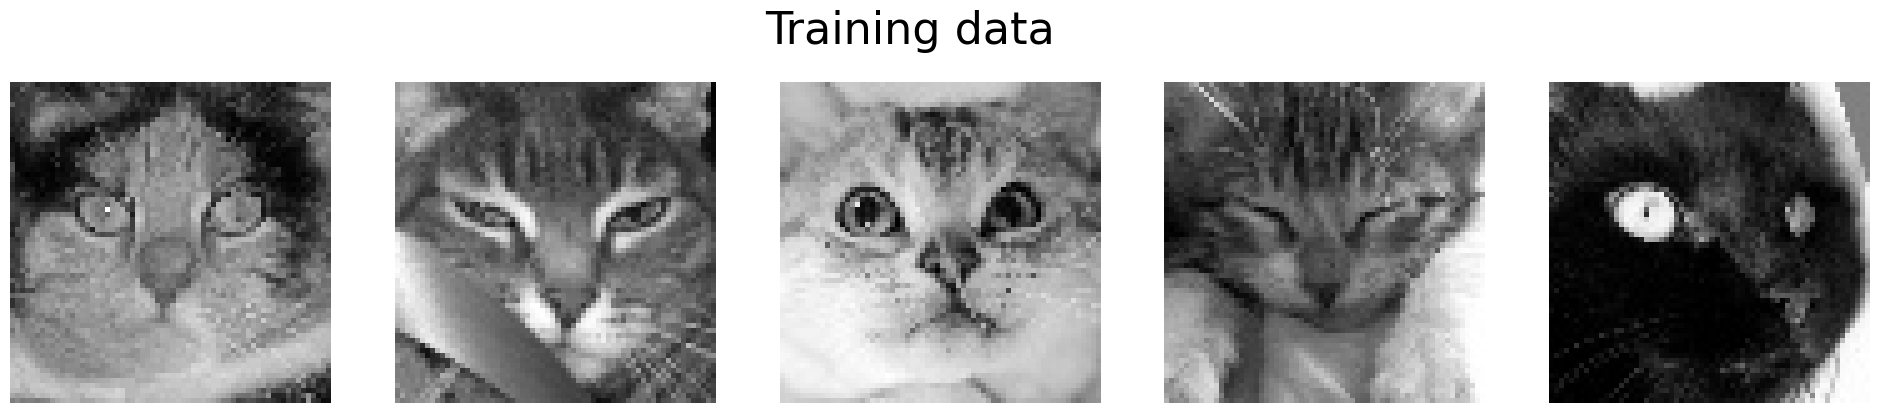

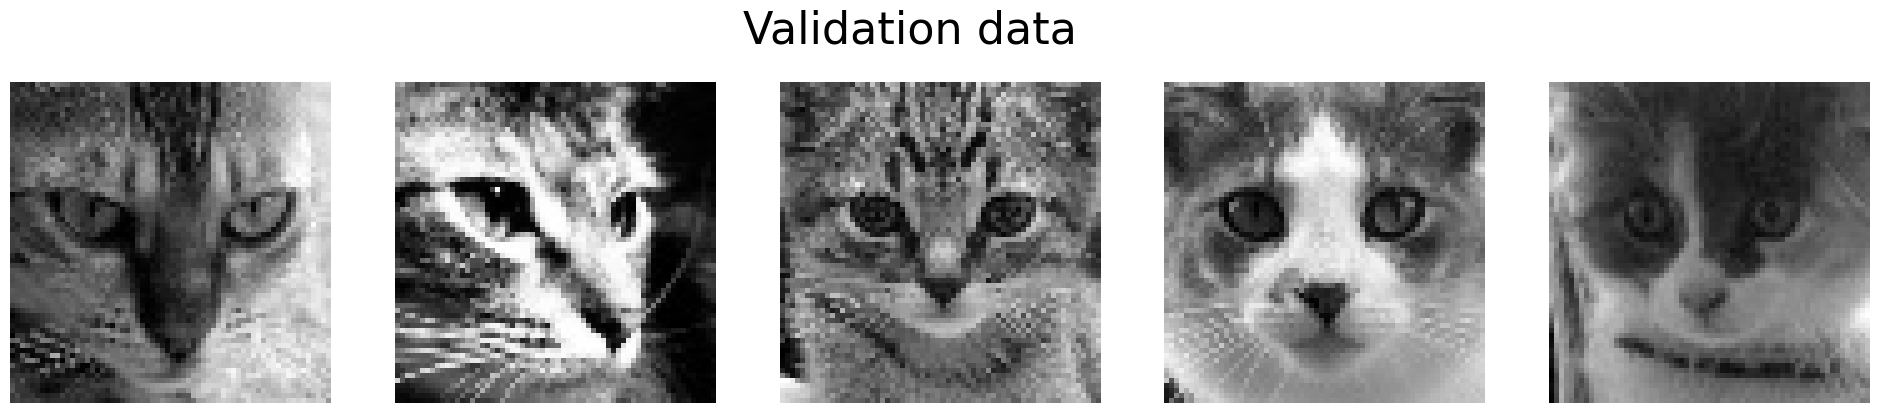

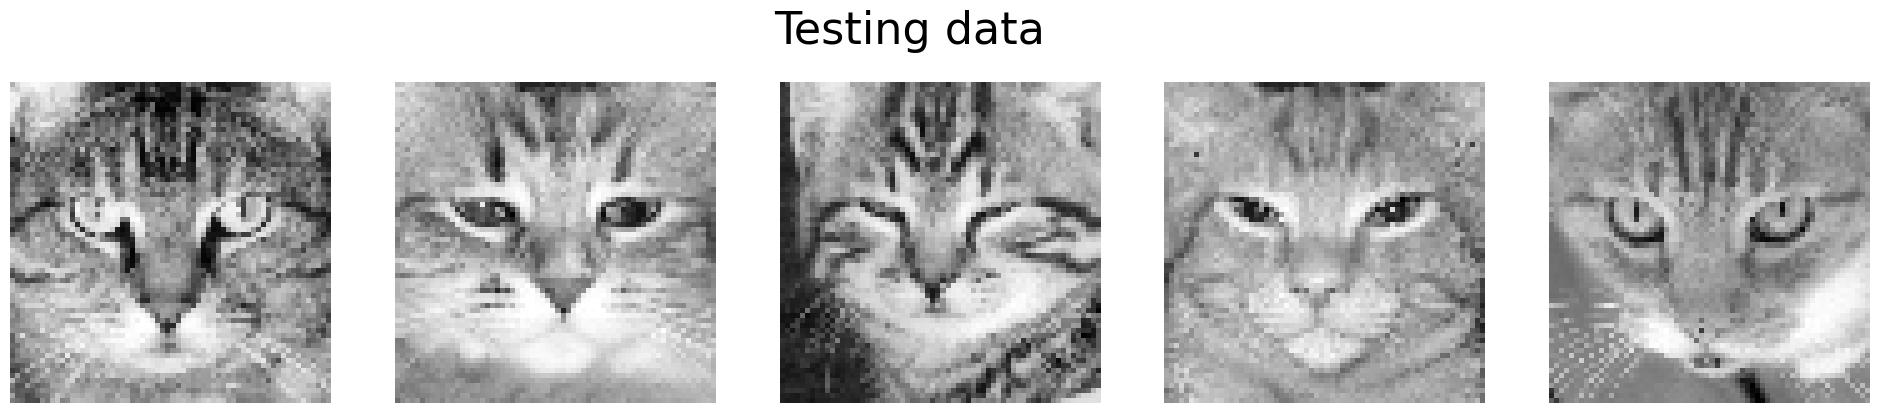

In [129]:
if visualize_datasets:
   def make_plt(dataset, title):
      fig, _ = plt.subplots(1, number_of_samples)
      fig.set_figwidth(24)
      fig.suptitle(title, fontsize=32)

      selected = np.random.choice(len(dataset), number_of_samples, False)
      for i, ind in enumerate(selected):
         plt.subplot(1, number_of_samples, i+1)
         # we permute: (?, 64, 64) --> (64, 64, ?)
         plt.imshow(dataset[ind].permute(1,2,0), cmap='gray')
         plt.axis('off')

   # training
   make_plt(train_dataset, "Training data")

   # validation
   make_plt(val_dataset, "Validation data")

   # testing
   make_plt(test_dataset, "Testing data")

else:
   print(f"Settable parameter 'visualize_datasets' is False" )


#### <font color='#C45A63'>[1.4] Create DataLoaders </font>

In [130]:
# training loader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# validation loader
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)

# testing loader
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

### <font color='#FFEC72'>[2] <u>Define AutoEncoders</u> </font>

#### <font color='#777'> [2.0] Imports</font>

In [131]:
import torch.nn as nn


#### <font color='#CEBD5C'> [2.1] Dense AutoEncoder Class</font>

In [132]:
class DenseAutoEncoder(nn.Module):
  def __init__(self):
    super(DenseAutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Flatten(), # (N, 64, 64) --> (N, 4096)
      nn.Linear(64*64, 24*24), # (N, 4096) --> (N, 256)
      nn.ReLU(),
      nn.Linear(24*24, 16*16),
      nn.ReLU(),
      nn.Linear(16*16, 4*4),
      nn.ReLU(),
      nn.Linear(4*4, 2*2)    # (N, 4)
    )

    self.decoder = nn.Sequential(
      nn.Linear(2*2, 4*4),
      nn.ReLU(),
      nn.Linear(4*4, 16*16),
      nn.ReLU(),
      nn.Linear(16*16, 24*24),
      nn.ReLU(),
      nn.Linear(24*24, 64*64),
      nn.Sigmoid()
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return decoded

#### <font color='#CEBD5C'> [2.2] Sparse AutoEncoder Class</font>

In [133]:
class SparseAutoEncoder(nn.Module):
  def __init__(self, l1_lam=0.001):
    super(SparseAutoEncoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Flatten(), # (N, 64, 64) --> (N, 4096)
      nn.Linear(64*64, 24*24), # (N, 4096) --> (N, 256)
      nn.ReLU(),
      nn.Linear(24*24, 16*16),
      nn.ReLU(),
      nn.Linear(16*16, 4*4),
      nn.ReLU(),
      nn.Linear(4*4, 2*2)    # (N, 4)
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    return decoded

  def l1_regularization(self):
    l1_norm = sum(torch.linalg.norm(p, 1) for p in self.parameters())
    return l1_lam * l1_norm


### <font color='#77FF5B'>[3] <u>Training Loop</u> </font>

#### <font color='#777'> [3.0] Imports</font>

In [134]:
import torch
import torch.nn as nn
import torch.optim as optim

#### <font color='#5EAA4C'> [3.1] Models, parameters</font>

In [135]:
num_epochs = 5
learning_rate = 0.001

# run the training on cuda gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dense model
dense_model = DenseAutoEncoder().to(device)
dense_criterion = nn.MSELoss()
# weight decay will work as l2 regularization
dense_optimizer = optim.Adam(dense_model.parameters(), lr=learning_rate, weight_decay=0.04)

# Sparse model
sparse_model = SparseAutoEncoder().to(device)
sparse_criterion = nn.MSELoss()
sparse_optimizer = optim.Adam(sparse_model.parameters(), lr=learning_rate)

#### <font color='#5EAA4C'> [3.2] Train DenseAutoEncoder</font>

In [136]:
original_images_list = []
reconstructed_images_list = []

for epoch in range(num_epochs):
  original_images_list.clear()
  reconstructed_images_list.clear()
  for i, image in enumerate(train_dataloader):
    print(f'\rEpoch {epoch+1}: {(((i+1) / len(train_dataloader))*100):.1f}%', end='')

    image = image.reshape(-1, 64*64).to(device)

    # forward pass
    reconstructed_image = dense_model(image)
    loss = dense_criterion(reconstructed_image, image)

    # backward pass
    dense_optimizer.zero_grad()
    loss.backward()
    dense_optimizer.step()

    original_images_list.append(image)
    reconstructed_images_list.append(reconstructed_image)

  print(f' Loss: {loss.item():.4f}')

Epoch 1: 100.0% Loss: 0.0738
Epoch 2: 100.0% Loss: 0.0389
Epoch 3: 100.0% Loss: 0.0555
Epoch 4: 100.0% Loss: 0.0841
Epoch 5: 100.0% Loss: 0.0704


#### <font color='#5EAA4C'> [3.3] Visualize original and reconstructed images</font>

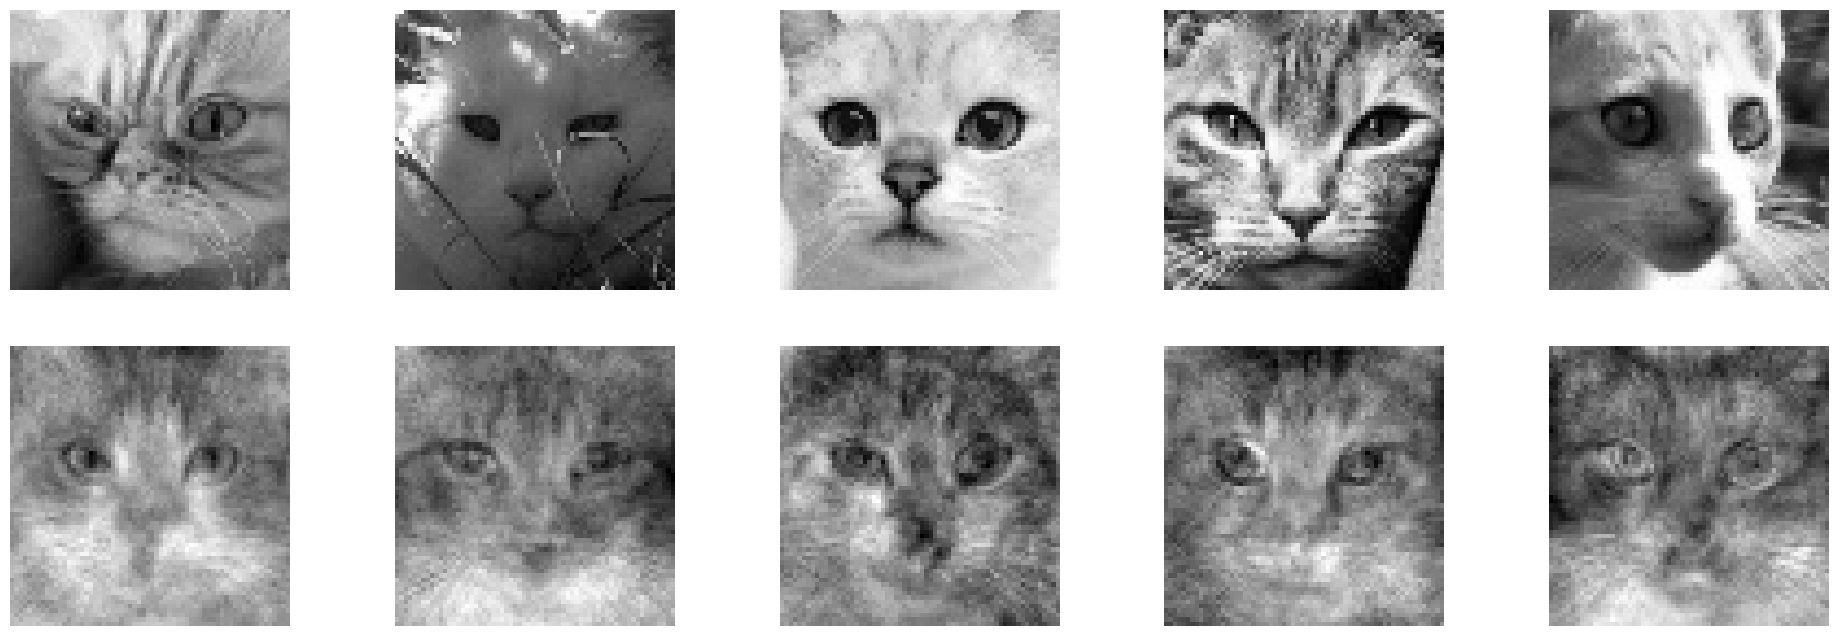

In [137]:
all_original_images = torch.cat(original_images_list, dim=0).reshape(-1,64,64)
all_reconstructed_images = torch.cat(reconstructed_images_list, dim=0).reshape(-1,64,64)

fig, _ = plt.subplots(2, 5)
fig.set_figwidth(24)
fig.set_figheight(8)

selected = np.random.choice(len(all_original_images), 5, False)
for i, ind in enumerate(selected):
    # original image
    plt.subplot(2, 5, i+1)
    image = all_original_images[ind]
    plt.imshow(image.cpu().detach(), cmap='gray')
    plt.axis('off')

    # reconstructed image
    plt.subplot(2, 5, i+6)
    image = all_reconstructed_images[ind]
    plt.imshow(image.cpu().detach(), cmap='gray')
    plt.axis('off')
